In [ ]:
%cd '/content/drive/MyDrive/Viettel/Detection/Red-light running detection'

/content/drive/MyDrive/Viettel/Detection/Red-light running detection


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler, ReduceLROnPlateau, ExponentialLR
from tqdm.notebook import tqdm
from keras.preprocessing import sequence
from torch.nn import functional as F

In [ ]:
def get_dir(list_file):
  '''
  Trả về đường dẫn đầy đủ của file
  '''
  list_dir = []
  for file_path in list_file:
    if "vungtau" in file_path:
      if os.path.exists(os.path.join("datasets/vungtau_1", file_path)):
        list_dir.append(os.path.join("datasets/vungtau_1", file_path, "info.csv"))
      else:
        list_dir.append(os.path.join("datasets/Test/den do 2", file_path, "info.csv"))
    else:
      if os.path.exists(os.path.join("datasets/Dendo1", file_path)):
        list_dir.append(os.path.join("datasets/Dendo1", file_path, "info.csv"))
      else:
        list_dir.append(os.path.join("datasets/Test/denxanh_hannam", file_path, "info.csv"))

  return list_dir

In [ ]:
def load_data(list_file):
  X = []
  Y = []
  info = []
  for file_name in list_file:
    df = pd.read_csv(file_name, dtype=np.float32)
    ids = df['id'].unique()

    # Lấy sequence theo ID và chuẩn hóa tọa độ bounding box về (0, 1)
    for id in ids:
      df_id = df[df['id'] == id]
      x = df_id.values[:, 3:7]
      y = df_id.values[:, -1]
      x[:, 0] = x[:, 0]/2560
      x[:, 1] = x[:, 1]/2560
      x[:, 2] = x[:, 2]/1920
      x[:, 3] = x[:, 3]/1920

      X.append(x)
      info.append([id, file_name]) # Lấy thông tin frame và id để phục vụ cho việc phân tích kết quả test
      if 1 in y:
        Y.append(1)
      else:
        Y.append(0)
    
  return X, Y, info

def dataloader(X, y, batch_size = 64):
  inputs = torch.tensor(X)
  labels = torch.tensor(y)

  data = TensorDataset(inputs, labels)
  sampler = SequentialSampler(data)
  dataloader = DataLoader(data, sampler=sampler,batch_size=batch_size)

  return dataloader

# Data test

In [ ]:
list_dir_test = []
list_file = os.listdir("datasets/vungtau_2")
for file_path in list_file:
  list_dir_test.append(os.path.join("datasets/vungtau_2", file_path, "info.csv"))

In [ ]:
X_test, y_test, info_test = load_data(list_dir_test)
X_test_pad = sequence.pad_sequences(X_test, maxlen=147, padding='pre', dtype='float32')
test_dataloader = dataloader(X_test_pad, y_test)
print(X_test_pad.shape)
print("Số lượng xe không vượt đèn đỏ, vượt đèn đỏ:")
print(y_test.count(0), y_test.count(1))

(254, 147, 4)
Số lượng xe không vượt đèn đỏ, vượt đèn đỏ:
44 210


# Data Train

In [ ]:
from sklearn.model_selection import train_test_split

path_denxanh = "datasets/vungtau_1"
path_dendo = "datasets/Dendo1" 
list_file_1 = os.listdir(path_dendo) + os.listdir(path_denxanh)
list_file_2 = os.listdir("datasets/Test/den do 2") + os.listdir("datasets/Test/denxanh_hannam")[:-2]
list_dir = get_dir(list_file_1) + get_dir(list_file_2)
list_dir.sort()
# list_train, list_test = train_test_split(list_dir, test_size=0.2, random_state=42)

In [ ]:
X, y, info = load_data(list_dir)
X_pad = sequence.pad_sequences(X, maxlen=147, padding='pre', dtype='float32')
print(X_pad.shape)
print("Số lượng xe không vượt đèn đỏ, vượt đèn đỏ:")
print(y.count(0), y.count(1))
y = np.array(y)

(1315, 147, 4)
Số lượng xe không vượt đèn đỏ, vượt đèn đỏ:
628 687


In [ ]:
# K-fold
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_pad, y))

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.3, random_state=42)
# train_dataloader = dataloader(X_train, y_train)
# val_dataloader = dataloader(X_val, y_val)
# print(X_train.shape, X_val.shape)
# print("Số lượng xe không vượt đèn đỏ, vượt đèn đỏ:")
# print(y_train.count(0), y_train.count(1))
# print(y_val.count(0), y_val.count(1))

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()

        # Defining the number of nodes in each layer
        self.hidden_dim = hidden_dim

        # LSTM layer
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_dim, hidden_dim, batch_first=True)
        self.lstm4 = nn.LSTM(3*hidden_dim, hidden_dim, batch_first=True)
        self.lstm5 = nn.LSTM(4*hidden_dim, hidden_dim, batch_first=True)
        self.lstm6 = nn.LSTM(5*hidden_dim, hidden_dim, batch_first=True)
        self.lstm7 = nn.LSTM(6*hidden_dim, hidden_dim, batch_first=True)
        self.lstm8 = nn.LSTM(7*hidden_dim, hidden_dim, batch_first=True)
        self.cnn1d = nn.Conv1d(in_channels=8*hidden_dim,out_channels=128, kernel_size=3, padding=1) # (64, 2048, 147) => (64, 128, 147)

        # Fully connected layer
        self.fc = nn.Linear(128, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out1, (h1, c1) = self.lstm1(x, (h0, c0))
        out2, (h2, c2) = self.lstm2(out1, (h1, c1))
        x2 = torch.cat((out1, out2), 2)
        out3, (h3, c3) = self.lstm3(x2, (h2, c2))
        x3 = torch.cat((out1, out2, out3), 2)
        out4, (h4, c4) = self.lstm4(x3, (h3, c3))
        x4 = torch.cat((out1, out2, out3, out4), 2)
        out5, (h5, c5) = self.lstm5(x4, (h4, c4))
        x5 = torch.cat((out1, out2, out3, out4, out5), 2)
        out6, (h6, c6) = self.lstm6(x5, (h5, c5))
        x6 = torch.cat((out1, out2, out3, out4, out5, out6), 2)
        out7, (h7, c7) = self.lstm7(x6, (h6, c6))
        x7 = torch.cat((out1, out2, out3, out4, out5, out6, out7), 2)
        out8, (h8, c8) = self.lstm8(x7, (h7, c7))
        x8 = torch.cat((out1, out2, out3, out4, out5, out6, out7, out8), 2)
        x8 = torch.transpose(x8, 1, 2)
        out = self.cnn1d(x8)
        out = torch.tanh(out)
        out, indices = F.max_pool1d(out ,out.size(2), return_indices=True)
        out = out.squeeze()
        out = self.fc(out)
        out = self.softmax(out)

        return out
    
    def init_hidden(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_dim)
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(1, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [ ]:
# Evaluate
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(labels_flat, pred_flat, average='macro')
    Precesion = precision_score(labels_flat, pred_flat, average= 'macro')
    Recall = recall_score(labels_flat, pred_flat, average= 'macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score, Precesion, Recall

In [ ]:
def train(model, X_train, y_train, X_val, y_val, lr = 0.0001, epochs = 100):
  train_dataloader = dataloader(X_train, y_train)
  val_dataloader = dataloader(X_val, y_val)

  criterion = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  sched = ReduceLROnPlateau(opt, threshold=1e-4, min_lr=1e-7)

  patience, trials = 25, 0
  best_f1 = 0
  train_fold_f1s, val_fold_f1s = [], []
  train_fold_pres, val_fold_pres = [], []
  train_fold_recall, val_fold_recall = [], []
  train_fold_losses, val_fold_losses = [], []

  for epoch in range(n_epochs):
    print('======== Epoch {:} ========'.format(epoch + 1))

    total_loss = 0
    model.train()
    train_accuracy = 0
    train_f1 = 0
    train_pre, train_re = 0, 0

    for step, batch in tqdm(enumerate(train_dataloader)):
      x_batch = batch[0].cuda()
      y_batch = batch[1].cuda().long()
      opt.zero_grad()
      out = model(x_batch)
      loss = criterion(out, y_batch)
      total_loss += loss.item()
      tmp_train_accuracy, tmp_train_f1, tmp_train_pre, tmp_train_re = flat_accuracy(out.detach().cpu().numpy(), y_batch.to('cpu').numpy())
      train_accuracy += tmp_train_accuracy
      train_f1 += tmp_train_f1
      train_pre += tmp_train_pre
      train_re += tmp_train_re

      
      loss.backward()
      opt.step()

    train_fold_f1s.append(train_f1/len(train_dataloader))
    train_fold_pres.append(train_pre/len(train_dataloader))
    train_fold_recall.append(train_re/len(train_dataloader))
    train_fold_losses.append(total_loss / len(train_dataloader))

    model.eval()
    total_val_loss = 0
    val_accuracy, val_f1 = 0, 0
    val_pre, val_re = 0, 0
    with torch.no_grad():
      for batch in tqdm(val_dataloader):
        x_val = batch[0].cuda()
        y_val = batch[1].cuda().long() 
        out = model(x_val)
        loss = criterion(out, y_val)
        total_val_loss += loss.item()
        tmp_eval_accuracy, tmp_eval_f1, tmp_eval_pre, tmp_eval_re = flat_accuracy(out.detach().cpu().numpy(), y_val.to('cpu').numpy())
        val_accuracy += tmp_eval_accuracy
        val_f1 += tmp_eval_f1
        val_pre += tmp_eval_pre
        val_re += tmp_eval_re
      
      val_loss = total_val_loss/len(val_dataloader)
      val_fold_f1s.append(val_f1/len(val_dataloader))
      val_fold_pres.append(val_pre/len(val_dataloader))
      val_fold_recall.append(val_re/len(val_dataloader))
      val_fold_losses.append(val_loss)
      sched.step(val_loss)
    
    val_f1 = val_f1 / len(val_dataloader)

    if val_f1 > best_f1:
        trials = 0
        best_f1 = val_f1
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch + 1}')
            break

  return train_fold_f1s, val_fold_f1s, train_fold_pres, val_fold_pres, train_fold_recall, val_fold_recall, train_fold_losses, val_fold_losses

In [ ]:
input_dim = 4 
hidden_dim = 256
output_dim = 2

lr = 0.0001
n_epochs = 100

train_f1s, val_f1s = [], []
train_pres, val_pres = [], []
train_recall, val_recall = [], []
train_losses, val_losses = [], []

for fold, (train_idx, val_idx) in enumerate(splits):
  print("Training for fold {}".format(fold))
  X_train, y_train = X_pad[train_idx], y[train_idx]
  X_val, y_val = X_pad[val_idx], y[val_idx]

  model = LSTMClassifier(input_dim, hidden_dim, output_dim)
  model = model.cuda()

  train_f1, val_f1, train_precision, val_precision, train_re, val_re, train_loss, val_loss = train(model, X_train, y_train, X_val, y_val)
  train_f1s.append(train_f1)
  val_f1s.append(val_f1)
  train_pres.append(train_precision)
  val_pres.append(val_precision)
  train_recall.append(train_re)
  val_recall.append(val_re)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  torch.save(model.state_dict(), os.path.join("weights", f"model_{fold}.pt"))

print("Complete training")

Training for fold 0
======== Epoch 1 ========


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:627: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



======== Epoch 2 ========



======== Epoch 3 ========



======== Epoch 4 ========



======== Epoch 5 ========



======== Epoch 6 ========



======== Epoch 7 ========



======== Epoch 8 ========



======== Epoch 9 ========



======== Epoch 10 ========



======== Epoch 11 ========



======== Epoch 12 ========



======== Epoch 13 ========



======== Epoch 14 ========



======== Epoch 15 ========



======== Epoch 16 ========



======== Epoch 17 ========



======== Epoch 18 ========



======== Epoch 19 ========



======== Epoch 20 ========



======== Epoch 21 ========



======== Epoch 22 ========



======== Epoch 23 ========



======== Epoch 24 ========



======== Epoch 25 ========



======== Epoch 26 ========



======== Epoch 27 ========



======== Epoch 28 ========



======== Epoch 29 ========



======== Epoch 30 ========



======== Epoch 31 ========



======== Epoch 32 ========



======== Epoch 33 ========



======== Epoch 34 ========



======== Epoch 35 ========



======== Epoch 36 ========



======== Epoch 37 ========



======== Epoch 38 ========



======== Epoch 39 ========



======== Epoch 40 ========



======== Epoch 41 ========



======== Epoch 42 ========



======== Epoch 43 ========



======== Epoch 44 ========



======== Epoch 45 ========



======== Epoch 46 ========



======== Epoch 47 ========



======== Epoch 48 ========



======== Epoch 49 ========



======== Epoch 50 ========



======== Epoch 51 ========



======== Epoch 52 ========



======== Epoch 53 ========



======== Epoch 54 ========



======== Epoch 55 ========



======== Epoch 56 ========



======== Epoch 57 ========



======== Epoch 58 ========



======== Epoch 59 ========



======== Epoch 60 ========



======== Epoch 61 ========



======== Epoch 62 ========



======== Epoch 63 ========



======== Epoch 64 ========



======== Epoch 65 ========



Early stopping on epoch 65
Training for fold 1
======== Epoch 1 ========



======== Epoch 2 ========



======== Epoch 3 ========


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



======== Epoch 4 ========



======== Epoch 5 ========



======== Epoch 6 ========



======== Epoch 7 ========



======== Epoch 8 ========



======== Epoch 9 ========



======== Epoch 10 ========



======== Epoch 11 ========



======== Epoch 12 ========



======== Epoch 13 ========



======== Epoch 14 ========



======== Epoch 15 ========



======== Epoch 16 ========



======== Epoch 17 ========



======== Epoch 18 ========



======== Epoch 19 ========



======== Epoch 20 ========



======== Epoch 21 ========



======== Epoch 22 ========



======== Epoch 23 ========



======== Epoch 24 ========



======== Epoch 25 ========



======== Epoch 26 ========



======== Epoch 27 ========



======== Epoch 28 ========



======== Epoch 29 ========



======== Epoch 30 ========



======== Epoch 31 ========



======== Epoch 32 ========



======== Epoch 33 ========



======== Epoch 34 ========



======== Epoch 35 ========



======== Epoch 36 ========



======== Epoch 37 ========



======== Epoch 38 ========



======== Epoch 39 ========



======== Epoch 40 ========



======== Epoch 41 ========



======== Epoch 42 ========



======== Epoch 43 ========



======== Epoch 44 ========



======== Epoch 45 ========



======== Epoch 46 ========



======== Epoch 47 ========



======== Epoch 48 ========



======== Epoch 49 ========



======== Epoch 50 ========



======== Epoch 51 ========



======== Epoch 52 ========



======== Epoch 53 ========



======== Epoch 54 ========



======== Epoch 55 ========



======== Epoch 56 ========



======== Epoch 57 ========



======== Epoch 58 ========



======== Epoch 59 ========



======== Epoch 60 ========



======== Epoch 61 ========



======== Epoch 62 ========



======== Epoch 63 ========



======== Epoch 64 ========



======== Epoch 65 ========



======== Epoch 66 ========



======== Epoch 67 ========



======== Epoch 68 ========



======== Epoch 69 ========



======== Epoch 70 ========



======== Epoch 71 ========



======== Epoch 72 ========



======== Epoch 73 ========



======== Epoch 74 ========



======== Epoch 75 ========



======== Epoch 76 ========



======== Epoch 77 ========



======== Epoch 78 ========



======== Epoch 79 ========



======== Epoch 80 ========



======== Epoch 81 ========



======== Epoch 82 ========



======== Epoch 83 ========



======== Epoch 84 ========



======== Epoch 85 ========



Early stopping on epoch 85
Training for fold 2
======== Epoch 1 ========



======== Epoch 2 ========



======== Epoch 3 ========



======== Epoch 4 ========



======== Epoch 5 ========



======== Epoch 6 ========



======== Epoch 7 ========



======== Epoch 8 ========



======== Epoch 9 ========



======== Epoch 10 ========



======== Epoch 11 ========



======== Epoch 12 ========



======== Epoch 13 ========



======== Epoch 14 ========



======== Epoch 15 ========



======== Epoch 16 ========



======== Epoch 17 ========



======== Epoch 18 ========



======== Epoch 19 ========



======== Epoch 20 ========



======== Epoch 21 ========



======== Epoch 22 ========



======== Epoch 23 ========



======== Epoch 24 ========



======== Epoch 25 ========



======== Epoch 26 ========



======== Epoch 27 ========



======== Epoch 28 ========



======== Epoch 29 ========



======== Epoch 30 ========



======== Epoch 31 ========



======== Epoch 32 ========



======== Epoch 33 ========



======== Epoch 34 ========



======== Epoch 35 ========



======== Epoch 36 ========



======== Epoch 37 ========



======== Epoch 38 ========



======== Epoch 39 ========



======== Epoch 40 ========



======== Epoch 41 ========



======== Epoch 42 ========



======== Epoch 43 ========



======== Epoch 44 ========



======== Epoch 45 ========



======== Epoch 46 ========



======== Epoch 47 ========



======== Epoch 48 ========



======== Epoch 49 ========



======== Epoch 50 ========



======== Epoch 51 ========



======== Epoch 52 ========



======== Epoch 53 ========



======== Epoch 54 ========



======== Epoch 55 ========



======== Epoch 56 ========



======== Epoch 57 ========



======== Epoch 58 ========



======== Epoch 59 ========



======== Epoch 60 ========



======== Epoch 61 ========



======== Epoch 62 ========



======== Epoch 63 ========



======== Epoch 64 ========



======== Epoch 65 ========



Early stopping on epoch 65
Training for fold 3
======== Epoch 1 ========



======== Epoch 2 ========



======== Epoch 3 ========



======== Epoch 4 ========



======== Epoch 5 ========



======== Epoch 6 ========



======== Epoch 7 ========



======== Epoch 8 ========



======== Epoch 9 ========



======== Epoch 10 ========



======== Epoch 11 ========



======== Epoch 12 ========



======== Epoch 13 ========



======== Epoch 14 ========



======== Epoch 15 ========



======== Epoch 16 ========



======== Epoch 17 ========



======== Epoch 18 ========



======== Epoch 19 ========



======== Epoch 20 ========



======== Epoch 21 ========



======== Epoch 22 ========



======== Epoch 23 ========



======== Epoch 24 ========



======== Epoch 25 ========



======== Epoch 26 ========



======== Epoch 27 ========



======== Epoch 28 ========



======== Epoch 29 ========



======== Epoch 30 ========



======== Epoch 31 ========



======== Epoch 32 ========



======== Epoch 33 ========



======== Epoch 34 ========



======== Epoch 35 ========



======== Epoch 36 ========



======== Epoch 37 ========



======== Epoch 38 ========



======== Epoch 39 ========



======== Epoch 40 ========



======== Epoch 41 ========



======== Epoch 42 ========



======== Epoch 43 ========



======== Epoch 44 ========



======== Epoch 45 ========



======== Epoch 46 ========



======== Epoch 47 ========



======== Epoch 48 ========



======== Epoch 49 ========



======== Epoch 50 ========



======== Epoch 51 ========



======== Epoch 52 ========



======== Epoch 53 ========



======== Epoch 54 ========



======== Epoch 55 ========



======== Epoch 56 ========



======== Epoch 57 ========



======== Epoch 58 ========



======== Epoch 59 ========



======== Epoch 60 ========



======== Epoch 61 ========



======== Epoch 62 ========



======== Epoch 63 ========



======== Epoch 64 ========



======== Epoch 65 ========



======== Epoch 66 ========



======== Epoch 67 ========



======== Epoch 68 ========



======== Epoch 69 ========



======== Epoch 70 ========



======== Epoch 71 ========



======== Epoch 72 ========



======== Epoch 73 ========



======== Epoch 74 ========



======== Epoch 75 ========



======== Epoch 76 ========



======== Epoch 77 ========



======== Epoch 78 ========



======== Epoch 79 ========



======== Epoch 80 ========



======== Epoch 81 ========



======== Epoch 82 ========



======== Epoch 83 ========



Early stopping on epoch 83
Training for fold 4
======== Epoch 1 ========



======== Epoch 2 ========



======== Epoch 3 ========



======== Epoch 4 ========



======== Epoch 5 ========



======== Epoch 6 ========



======== Epoch 7 ========



======== Epoch 8 ========



======== Epoch 9 ========



======== Epoch 10 ========



======== Epoch 11 ========



======== Epoch 12 ========



======== Epoch 13 ========



======== Epoch 14 ========



======== Epoch 15 ========



======== Epoch 16 ========



======== Epoch 17 ========



======== Epoch 18 ========



======== Epoch 19 ========



======== Epoch 20 ========



======== Epoch 21 ========



======== Epoch 22 ========



======== Epoch 23 ========



======== Epoch 24 ========



======== Epoch 25 ========



======== Epoch 26 ========



======== Epoch 27 ========



======== Epoch 28 ========



======== Epoch 29 ========



======== Epoch 30 ========



======== Epoch 31 ========



======== Epoch 32 ========



======== Epoch 33 ========



======== Epoch 34 ========



======== Epoch 35 ========



======== Epoch 36 ========



======== Epoch 37 ========



======== Epoch 38 ========



======== Epoch 39 ========



======== Epoch 40 ========



======== Epoch 41 ========



======== Epoch 42 ========



======== Epoch 43 ========



Early stopping on epoch 43
Complete training


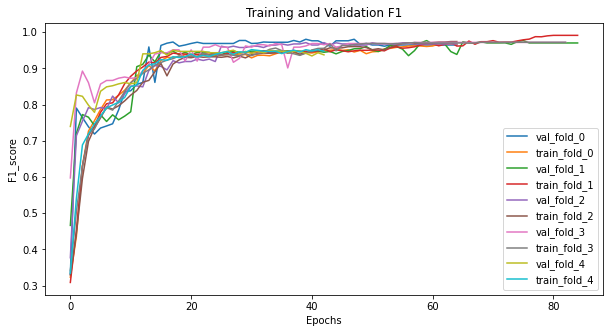

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation F1")
plt.plot(val_f1s[0],label="val_fold_0")
plt.plot(train_f1s[0],label="train_fold_0")
plt.plot(val_f1s[1],label="val_fold_1")
plt.plot(train_f1s[1],label="train_fold_1")
plt.plot(val_f1s[2],label="val_fold_2")
plt.plot(train_f1s[2],label="train_fold_2")
plt.plot(val_f1s[3],label="val_fold_3")
plt.plot(train_f1s[3],label="train_fold_3")
plt.plot(val_f1s[4],label="val_fold_4")
plt.plot(train_f1s[4],label="train_fold_4")
plt.xlabel("Epochs")
plt.ylabel("F1_score")
plt.legend()
plt.show()

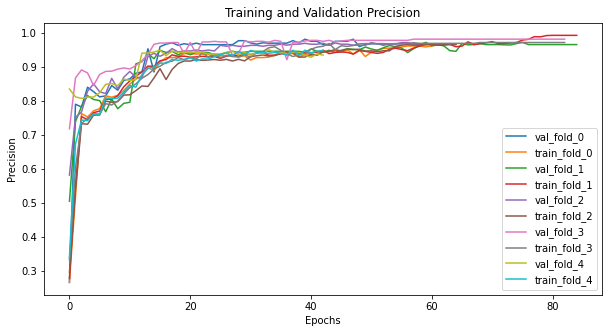

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Precision")
plt.plot(val_pres[0],label="val_fold_0")
plt.plot(train_pres[0],label="train_fold_0")
plt.plot(val_pres[1],label="val_fold_1")
plt.plot(train_pres[1],label="train_fold_1")
plt.plot(val_pres[2],label="val_fold_2")
plt.plot(train_pres[2],label="train_fold_2")
plt.plot(val_pres[3],label="val_fold_3")
plt.plot(train_pres[3],label="train_fold_3")
plt.plot(val_pres[4],label="val_fold_4")
plt.plot(train_pres[4],label="train_fold_4")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.show()

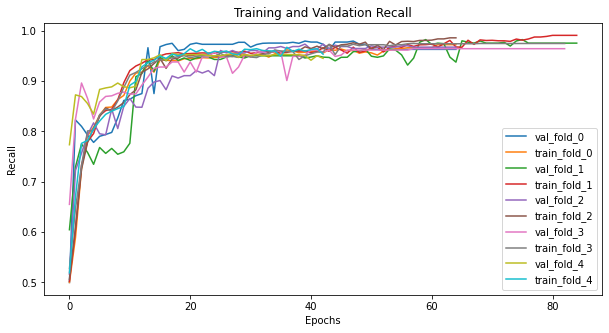

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Recall")
plt.plot(val_recall[0],label="val_fold_0")
plt.plot(train_recall[0],label="train_fold_0")
plt.plot(val_recall[1],label="val_fold_1")
plt.plot(train_recall[1],label="train_fold_1")
plt.plot(val_recall[2],label="val_fold_2")
plt.plot(train_recall[2],label="train_fold_2")
plt.plot(val_recall[3],label="val_fold_3")
plt.plot(train_recall[3],label="train_fold_3")
plt.plot(val_recall[4],label="val_fold_4")
plt.plot(train_recall[4],label="train_fold_4")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

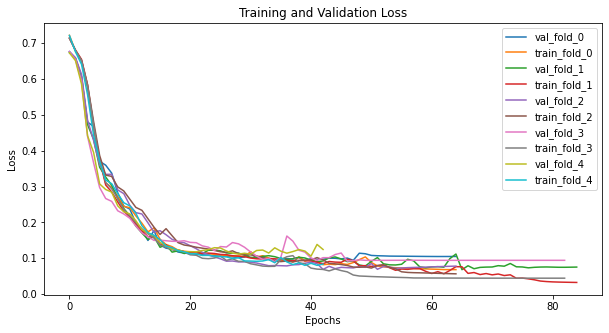

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses[0],label="val_fold_0")
plt.plot(train_losses[0],label="train_fold_0")
plt.plot(val_losses[1],label="val_fold_1")
plt.plot(train_losses[1],label="train_fold_1")
plt.plot(val_losses[2],label="val_fold_2")
plt.plot(train_losses[2],label="train_fold_2")
plt.plot(val_losses[3],label="val_fold_3")
plt.plot(train_losses[3],label="train_fold_3")
plt.plot(val_losses[4],label="val_fold_4")
plt.plot(train_losses[4],label="train_fold_4")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# input_dim = 4 
# hidden_dim = 256
# output_dim = 2

# model = LSTMClassifier(input_dim, hidden_dim, output_dim)
# model.load_state_dict(torch.load("weights/LSTM8_conv1d_maxpool_99.2f1_Adam.pt"))
# model = model.cuda()

In [ ]:
model.eval()

LSTMClassifier(
  (lstm1): LSTM(4, 256, batch_first=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (lstm3): LSTM(512, 256, batch_first=True)
  (lstm4): LSTM(768, 256, batch_first=True)
  (lstm5): LSTM(1024, 256, batch_first=True)
  (lstm6): LSTM(1280, 256, batch_first=True)
  (lstm7): LSTM(1536, 256, batch_first=True)
  (lstm8): LSTM(1792, 256, batch_first=True)
  (cnn1d): Conv1d(2048, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
model.load_state_dict(torch.load("weights/model_0.pt"))

<All keys matched successfully>

In [ ]:
y_pred = []
print('Predicting on test dataset')
for batch in test_dataloader:
    x_test = batch[0].cuda()
    out = model(x_test)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_pred += y_hat.tolist()

Predicting on test dataset


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score, recall_score, f1_score, accuracy_score

print('accuracy ',accuracy_score(y_test,y_pred))
print('precision ', precision_score(y_test,y_pred,average= 'macro'))
print('recall ', recall_score(y_test,y_pred,average= 'macro'))
print("f1", f1_score(y_test,y_pred, average= 'macro'))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test,y_pred)

accuracy  0.9921259842519685
precision  0.9862554112554113
recall  0.9862554112554113
f1 0.9862554112554113
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       1.00      1.00      1.00       210

    accuracy                           0.99       254
   macro avg       0.99      0.99      0.99       254
weighted avg       0.99      0.99      0.99       254



array([[ 43,   1],
       [  1, 209]])

In [ ]:
miss_label = []
for i in range(len(y_test)):
  if y_test[i] != y_pred[i]:
    miss_label.append(i)

In [ ]:
for i in miss_label:
  print(info_test[i], y_pred[i])

[124.0, 'datasets/vungtau_2/vungtau_191.0.avi_save/info.csv'] 0
[83.0, 'datasets/vungtau_2/vungtau_163.0.avi_save/info.csv'] 1


In [ ]:
# Save model
# torch.save(model.state_dict(), "weights/LSTM8_conv1d_maxpool_97.9f1_Adam.pt")

In [ ]:
print("Fold 0:")
print(max(train_f1s[0]), max(val_f1s[0]))
print(max(train_pres[0]), max(val_pres[0]))
print(max(train_recall[0]), max(val_recall[0]))
print(min(train_losses[0]), min(val_losses[0]))

Fold 0:
0.9671769099573547 0.9805036944314054
0.9650425531896616 0.9815497835497837
0.9724581990806027 0.9795829098437794
0.0680382932700655 0.09251989759504795


In [ ]:
print("Fold 1:")
print(max(train_f1s[1]), max(val_f1s[1]))
print(max(train_pres[1]), max(val_pres[1]))
print(max(train_recall[1]), max(val_recall[1]))
print(min(train_losses[1]), min(val_losses[1]))

Fold 1:
0.9912897219000331 0.9768451323025188
0.9928451178451179 0.9722809348953779
0.9909186401833461 0.9825125795403731
0.03227328883675749 0.06795942294411361


In [ ]:
print("Fold 2")
print(max(train_f1s[2]), max(val_f1s[2]))
print(max(train_pres[2]), max(val_pres[2]))
print(max(train_recall[2]), max(val_recall[2]))
print(min(train_losses[2]), min(val_losses[2]))

Fold 2
0.9741528648199913 0.9712355857909893
0.9672352636706857 0.9714090732695384
0.9859977799169203 0.9734719227008088
0.0563475956373355 0.06874640211462975


In [ ]:
print("Fold 3:")
print(max(train_f1s[3]), max(val_f1s[3]))
print(max(train_pres[3]), max(val_pres[3]))
print(max(train_recall[3]), max(val_recall[3]))
print(min(train_losses[3]), min(val_losses[3]))

Fold 3:
0.9721252069648647 0.9718575615671042
0.9717550295860837 0.98165296279582
0.974842473830086 0.964426926926927
0.044174425276544166 0.09018996302038432


In [ ]:
print("Fold 4:")
print(max(train_f1s[4]), max(val_f1s[4]))
print(max(train_pres[4]), max(val_pres[4]))
print(max(train_recall[4]), max(val_recall[4]))
print(min(train_losses[4]), min(val_losses[4]))

Fold 4:
0.9517803099951093 0.9502737877149896
0.9490894060360006 0.9503737792757757
0.9673081890117534 0.9550087501151332
0.07997456434018471 0.10565353110432625
